# 021 - Sklearn DuckDB SQL Clustering (Sklearn Visualizations)

This notebook mirrors the **DuckDB SQL preprocessing** used in the SvelteKit Batch ML clustering flow,
but excludes YellowBrick so we can focus on native sklearn visualization APIs.

In [1]:
import duckdb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay, DecisionBoundaryDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LearningCurveDisplay, ValidationCurveDisplay
from sklearn.preprocessing import StandardScaler


In [2]:
MINIO_HOST = "localhost"
MINIO_PORT = "9000"
MINIO_ENDPOINT = f"{MINIO_HOST}:{MINIO_PORT}"
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin123"
PROJECT_NAME = "E-Commerce Customer Interactions"

In [3]:
DELTA_PATHS = {
    "Transaction Fraud Detection": "s3://lakehouse/delta/transaction_fraud_detection",
    "Estimated Time of Arrival": "s3://lakehouse/delta/estimated_time_of_arrival",
    "E-Commerce Customer Interactions": "s3://lakehouse/delta/e_commerce_customer_interactions",
}

delta_path = DELTA_PATHS.get(PROJECT_NAME)

In [4]:
# Disable AWS EC2 metadata service lookup (prevents 169.254.169.254 errors)
os.environ["AWS_EC2_METADATA_DISABLED"] = "true"

# Create connection (in-memory database)
conn = duckdb.connect()

# Install and load required extensions
conn.execute("INSTALL delta; LOAD delta;")
conn.execute("INSTALL httpfs; LOAD httpfs;")

# Create a secret for S3/MinIO credentials
conn.execute(f"""
    CREATE SECRET minio_secret (
        TYPE S3,
        KEY_ID '{MINIO_ACCESS_KEY}',
        SECRET '{MINIO_SECRET_KEY}',
        REGION 'us-east-1',
        ENDPOINT '{MINIO_ENDPOINT}',
        URL_STYLE 'path',
        USE_SSL false
    );
""")
print("DuckDB extensions loaded and S3 secret configured")

DuckDB extensions loaded and S3 secret configured


## Feature Definitions

Event-level clustering features for ECCI.

In [5]:
ECCI_NUMERICAL_FEATURES = [
    "price",
    "quantity",
    "time_on_page_seconds",
    "session_event_sequence",
]

ECCI_CATEGORICAL_FEATURES = [
    "event_type",
    "product_category",
    "product_id",
    "referrer_url",
    "browser",
    "os",
    "year",
    "month",
    "day",
    "hour",
    "minute",
    "second",
]

ECCI_ALL_FEATURES = ECCI_NUMERICAL_FEATURES + ECCI_CATEGORICAL_FEATURES
ECCI_CAT_FEATURE_INDICES = list(range(len(ECCI_NUMERICAL_FEATURES), len(ECCI_ALL_FEATURES)))

print(f"Numerical features: {len(ECCI_NUMERICAL_FEATURES)}")
print(f"Categorical features: {len(ECCI_CATEGORICAL_FEATURES)}")
print(f"Total features: {len(ECCI_ALL_FEATURES)}")
print(f"Categorical indices: {ECCI_CAT_FEATURE_INDICES}")

Numerical features: 4
Categorical features: 12
Total features: 16
Categorical indices: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


## Data Loading with DuckDB SQL

In [6]:
def load_event_data(
    delta_path: str,
    sample_frac: float | None = None,
    max_rows: int | None = None,
) -> pd.DataFrame:
    """
    Load ECCI event-level data using DuckDB SQL with DENSE_RANK encoding.

    Same pattern as TFD and ETA - no aggregation.
    Each row is one event.
    """
    query = f"""
    SELECT
        COALESCE(price, 0) AS price,
        COALESCE(quantity, 0) AS quantity,
        COALESCE(time_on_page_seconds, 0) AS time_on_page_seconds,
        COALESCE(session_event_sequence, 0) AS session_event_sequence,

        DENSE_RANK() OVER (ORDER BY event_type) - 1 AS event_type,
        DENSE_RANK() OVER (ORDER BY COALESCE(product_category, 'unknown')) - 1 AS product_category,
        DENSE_RANK() OVER (ORDER BY COALESCE(product_id, 'unknown')) - 1 AS product_id,
        DENSE_RANK() OVER (ORDER BY COALESCE(referrer_url, 'unknown')) - 1 AS referrer_url,
        DENSE_RANK() OVER (ORDER BY COALESCE(device_info->>'browser', 'unknown')) - 1 AS browser,
        DENSE_RANK() OVER (ORDER BY COALESCE(device_info->>'os', 'unknown')) - 1 AS os,

        CAST(date_part('year', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS year,
        CAST(date_part('month', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS month,
        CAST(date_part('day', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS day,
        CAST(date_part('hour', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS hour,
        CAST(date_part('minute', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS minute,
        CAST(date_part('second', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS second

    FROM delta_scan('{delta_path}')
    """

    if sample_frac is not None and 0 < sample_frac < 1:
        query += f" USING SAMPLE {sample_frac * 100}%"
    if max_rows:
        query += f" LIMIT {max_rows}"

    print("Loading event-level data (DENSE_RANK encoding)...")
    if sample_frac:
        print(f"  Sampling: {sample_frac * 100}%")
    if max_rows:
        print(f"  Max rows: {max_rows}")

    df = conn.execute(query).df()
    print(f"  Loaded {len(df):,} events with {len(df.columns)} columns")
    print(f"  All features numeric: {df.select_dtypes(include=['number']).shape[1]}/{df.shape[1]} columns")
    return df

In [7]:
def load_text_data(
    delta_path: str,
    max_rows: int | None = None,
) -> pd.DataFrame:
    """Load raw event data with text fields for optional text analysis."""
    query = f"""
    SELECT
        customer_id,
        event_type,
        search_query,
        page_url,
        product_category,
        referrer_url
    FROM delta_scan('{delta_path}')
    WHERE search_query IS NOT NULL AND search_query != ''
    """

    if max_rows:
        query += f" LIMIT {max_rows}"

    print("Loading text data (search queries)...")
    df = conn.execute(query).df()
    print(f"  Loaded {len(df):,} search events")
    return df

In [8]:
MODEL_TYPE = "kmeans"
df = load_event_data(delta_path, max_rows=10000)
df_text = load_text_data(delta_path, max_rows=5000)

Loading event-level data (DENSE_RANK encoding)...
  Max rows: 10000


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 10,000 events with 16 columns
  All features numeric: 16/16 columns
Loading text data (search queries)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 5,000 search events


## Data Preprocessing

In [9]:
def process_data_for_clustering(
    df: pd.DataFrame,
    scale: bool = True,
) -> tuple[pd.DataFrame, np.ndarray, list[str], StandardScaler | None]:
    """
    Process event data for clustering.
    
    Args:
        df: Event-level DataFrame (all columns are features)
        scale: Whether to standardize features
    
    Returns:
        Tuple of (original_df, X_scaled, feature_names, scaler)
    """
    feature_cols = list(df.columns)
    X = df[feature_cols].copy()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    scaler = None
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.values

    print(f"Features: {len(feature_cols)}")
    print(f"Data shape: {X_scaled.shape}")

    return df, X_scaled, feature_cols, scaler

df_original, X_scaled, feature_names, scaler = process_data_for_clustering(df)

Features: 16
Data shape: (10000, 16)


## Model Creation & Clustering

In [10]:
def create_clustering_model(n_clusters: int = 6):
    return KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300,
        tol=1e-4,
        random_state=42,
        algorithm='lloyd',
    )

kmeans_model = create_clustering_model(n_clusters=6)
cluster_labels = kmeans_model.fit_predict(X_scaled)
df_original['cluster'] = cluster_labels
print('Cluster labels assigned.')

Cluster labels assigned.


## Sklearn Visualization API (Clustering)

Sklearn does not provide cluster-specific display objects, so we use
supervised displays on pseudo-labels (cluster IDs).

In [11]:
feature_names = list(feature_names)
categorical_features = [
    feature_names.index(name)
    for name in ECCI_CATEGORICAL_FEATURES
    if name in feature_names
]

rf_estimator = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)
rf_estimator.fit(X_scaled, cluster_labels)
print('RandomForest classifier fitted on cluster labels.')

boundary_candidates = [
    'price',
    'time_on_page_seconds',
    'quantity',
    'session_event_sequence',
]
boundary_features = [name for name in boundary_candidates if name in feature_names]
if len(boundary_features) < 2:
    boundary_features = feature_names[:2]
else:
    boundary_features = boundary_features[:2]

boundary_indices = [feature_names.index(name) for name in boundary_features]
X_boundary = X_scaled[:, boundary_indices]

boundary_estimator = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)
boundary_estimator.fit(X_boundary, cluster_labels)
print(f'Boundary RandomForest fitted on {boundary_features}.')


RandomForest classifier fitted on cluster labels.
Boundary RandomForest fitted on ['price', 'time_on_page_seconds'].


In [12]:
SKLEARN_VIZ_PATH = 'models/e_commerce_customer_interactions/sklearn_visualizations'
os.makedirs(SKLEARN_VIZ_PATH, exist_ok=True)

def save_display(display, filename: str, show: bool = True) -> str:
    output_path = os.path.join(SKLEARN_VIZ_PATH, filename)
    if show:
        plt.show()
    display.figure_.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(display.figure_)
    return output_path

In [13]:
def sklearn_clustering_viz_kwargs():
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    return {
        'decision_boundary': {
            'grid_resolution': 200,
            'eps': 0.5,
            'plot_method': 'contourf',
            'response_method': 'predict_proba',
            'class_of_interest': 0,
            'xlabel': boundary_features[0],
            'ylabel': boundary_features[1],
        },
        'partial_dependence': {
            'features': [
                'price',
                'time_on_page_seconds',
                'event_type',
                'product_category',
            ],
            'categorical_features': categorical_features,
            'feature_names': feature_names,
            'target': 0,
            'response_method': 'predict_proba',
            'grid_resolution': 50,
            'percentiles': (0.05, 0.95),
            'n_cols': 2,
            'subsample': 2000,
            'random_state': 42,
            'kind': 'average',
            'line_kw': {
                'linewidth': 2,
                'color': '#1f77b4',
            },
        },
        'learning_curve': {
            'train_sizes': np.linspace(0.1, 1.0, 5),
            'cv': cv,
            'scoring': 'accuracy',
            'shuffle': True,
            'random_state': 42,
            'score_type': 'both',
            'std_display_style': 'fill_between',
            'line_kw': {
                'linewidth': 2,
            },
            'fill_between_kw': {
                'alpha': 0.2,
            },
        },
        'validation_curve': {
            'param_name': 'max_depth',
            'param_range': [4, 8, 12, 16],
            'cv': cv,
            'scoring': 'accuracy',
            'score_type': 'both',
            'std_display_style': 'fill_between',
            'line_kw': {
                'linewidth': 2,
            },
            'fill_between_kw': {
                'alpha': 0.2,
            },
        },
    }


In [14]:
def sklearn_clustering_visualizers(viz_config: dict):
    results = {}
    errors = []
    total = 0

    def run_display(name, builder):
        nonlocal total
        total += 1
        try:
            display = builder()
            results[name] = save_display(display, f'{name}.png', show=True)
            print(f'  OK: {name} saved')
        except Exception as exc:
            errors.append((name, str(exc)))
            print(f'  FAILED: {name} failed: {exc}')

    print('')
    print('=== Sklearn Clustering Visualization Run ===')

    def decision_boundary_builder():
        fig, ax = plt.subplots(figsize=(6, 5))
        display = DecisionBoundaryDisplay.from_estimator(
            boundary_estimator,
            X_boundary,
            ax=ax,
            **viz_config['decision_boundary'],
        )
        ax.scatter(
            X_boundary[:, 0],
            X_boundary[:, 1],
            c=cluster_labels,
            cmap='viridis',
            alpha=0.5,
            s=12,
            edgecolor='k',
        )
        ax.set_title('Decision Boundary (Cluster Labels)')
        return display

    run_display('DecisionBoundaryDisplay', decision_boundary_builder)
    run_display(
        'PartialDependenceDisplay',
        lambda: PartialDependenceDisplay.from_estimator(
            rf_estimator, X_scaled, **viz_config['partial_dependence']
        ),
    )
    run_display(
        'LearningCurveDisplay',
        lambda: LearningCurveDisplay.from_estimator(
            rf_estimator, X_scaled, cluster_labels, **viz_config['learning_curve']
        ),
    )
    run_display(
        'ValidationCurveDisplay',
        lambda: ValidationCurveDisplay.from_estimator(
            rf_estimator, X_scaled, cluster_labels, **viz_config['validation_curve']
        ),
    )

    print('')
    print(f'Saved {len(results)} of {total} sklearn visualizations.')
    if errors:
        print('Failures:')
        for name, error in errors:
            print(f'  {name}: {error}')
    return results



=== Sklearn Clustering Visualization Run ===


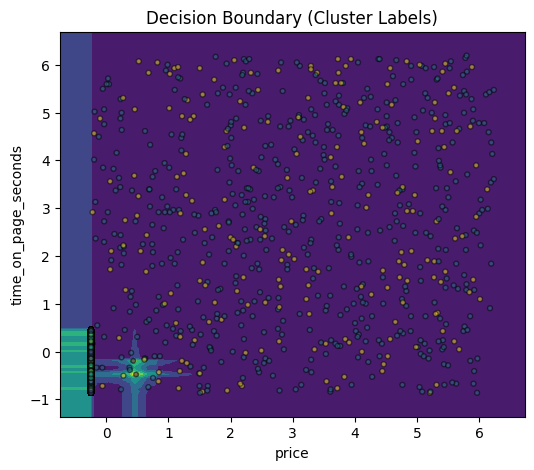

  OK: DecisionBoundaryDisplay saved


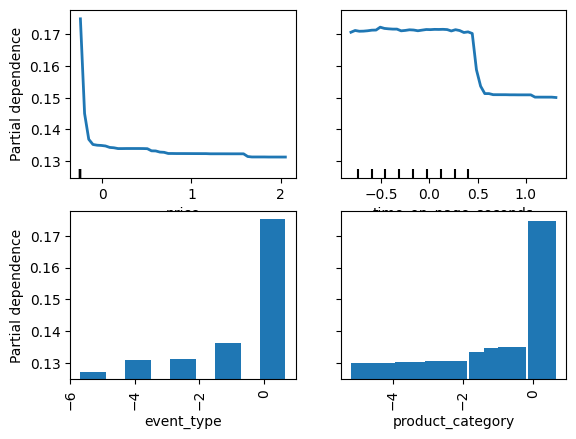

  OK: PartialDependenceDisplay saved


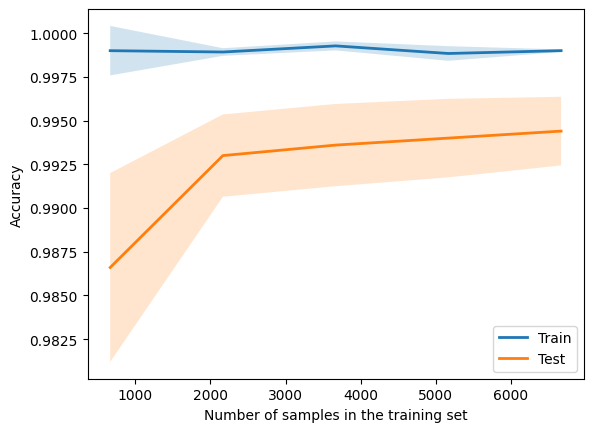

  OK: LearningCurveDisplay saved


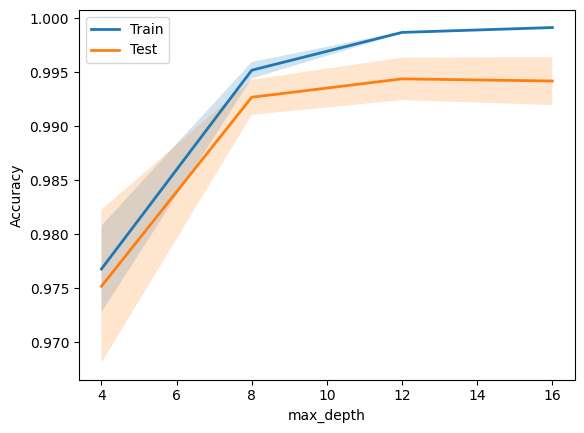

  OK: ValidationCurveDisplay saved

Saved 4 of 4 sklearn visualizations.


In [15]:
viz_config = sklearn_clustering_viz_kwargs()
results = sklearn_clustering_visualizers(viz_config)

## Scikit-plot Visualization API (Clustering)

Scikit-plot provides clusterer and silhouette plots that map cleanly
to the Batch ML metrics tabs.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
if not hasattr(scipy, "interp"):
    scipy.interp = np.interp
import scikitplot as skplt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

if not hasattr(scipy, 'interp'):
    scipy.interp = np.interp

SCIKITPLOT_PATH = 'models/e_commerce_customer_interactions/scikitplot_visualizations'
os.makedirs(SCIKITPLOT_PATH, exist_ok=True)

def save_plot(ax, filename: str, show: bool = True) -> str:
    output_path = os.path.join(SCIKITPLOT_PATH, filename)
    if show:
        plt.show()
    ax.get_figure().savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(ax.get_figure())
    return output_path

In [18]:
# Inspect sklearn/scikit-plot visualizer surface for clustering
import inspect, pkgutil, importlib, sklearn

sklearn_displays = {}
for modinfo in pkgutil.walk_packages(sklearn.__path__, sklearn.__name__ + '.'):
    name = modinfo.name
    try:
        mod = importlib.import_module(name)
    except Exception:
        continue
    for attr_name in dir(mod):
        if attr_name.endswith('Display'):
            sklearn_displays.setdefault(name, []).append(attr_name)

skplot_funcs = {}
for modinfo in pkgutil.walk_packages(skplt.__path__, skplt.__name__ + '.'):
    name = modinfo.name
    try:
        mod = importlib.import_module(name)
    except Exception:
        continue
    for attr_name, attr in vars(mod).items():
        if attr_name.startswith('plot_') and inspect.isfunction(attr):
            skplot_funcs.setdefault(name, []).append(attr_name)

sklearn_display_names = sorted({d for v in sklearn_displays.values() for d in v})
skplot_names = sorted({f for v in skplot_funcs.values() for f in v})

print('Sklearn Display classes:', sklearn_display_names)
print('Scikit-plot plot_* functions:', skplot_names)

# Clustering-focused subset
cluster_related = [
    'DecisionBoundaryDisplay',
    'PartialDependenceDisplay',
    'LearningCurveDisplay',
    'ValidationCurveDisplay',
]
skplot_cluster_related = [
    'plot_elbow_curve',
    'plot_silhouette',
    'plot_pca_2d_projection',
    'plot_pca_component_variance',
    'plot_learning_curve',
    'plot_feature_importances',
]
print('Cluster-related sklearn displays (used):', cluster_related)
print('Cluster-related scikit-plot functions (used):', skplot_cluster_related)


1.8.0


/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Sklearn Display classes: ['CalibrationDisplay', 'ConfusionMatrixDisplay', 'DecisionBoundaryDisplay', 'DetCurveDisplay', 'LearningCurveDisplay', 'PartialDependenceDisplay', 'PrecisionRecallDisplay', 'PredictionErrorDisplay', 'RocCurveDisplay', 'ValidationCurveDisplay', '_BaseCurveDisplay']
Scikit-plot plot_* functions: ['plot_calibration_curve', 'plot_confusion_matrix', 'plot_confusion_matrix_with_cv', 'plot_cumulative_gain', 'plot_elbow_curve', 'plot_feature_importances', 'plot_ks_statistic', 'plot_ks_statistic_with_cv', 'plot_learning_curve', 'plot_lift_curve', 'plot_pca_2d_projection', 'plot_pca_component_variance', 'plot_precision_recall', 'plot_precision_recall_curve', 'plot_precision_recall_curve_with_cv', 'plot_roc', 'plot_roc_curve', 'plot_roc_curve_with_cv', 'plot_silhouette']
Cluster-related sklearn displays (used): ['DecisionBoundaryDisplay', 'PartialDependenceDisplay', 'LearningCurveDisplay', 'ValidationCurveDisplay']
Cluster-related scikit-plot functions (used): ['plot_elbo

In [19]:
def scikitplot_clustering_kwargs():
    return {
        'plot_elbow_curve': {
            'cluster_ranges': range(2, 11),
            'show_cluster_time': True,
            'n_jobs': 1,
            'title': 'Elbow Plot (KMeans)',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_silhouette': {
            'metric': 'euclidean',
            'cmap': 'nipy_spectral',
            'title': 'Silhouette Analysis',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_pca_component_variance': {
            'target_explained_variance': 0.8,
            'title': 'PCA Component Explained Variance',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_pca_2d_projection': {
            'biplot': False,
            'cmap': 'Spectral',
            'title': 'PCA 2-D Projection',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_learning_curve': {
            'cv': 3,
            'train_sizes': np.linspace(0.1, 1.0, 5),
            'scoring': 'accuracy',
            'n_jobs': 1,
            'title': 'Learning Curve',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_feature_importances': {
            'title': 'Cluster Feature Importances',
            'feature_names': feature_names,
            'max_num_features': 20,
            'order': 'descending',
            'x_tick_rotation': 45,
            'figsize': (8, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
    }


In [22]:
def scikitplot_clustering_visualizers(cfg: dict):
    results = {}
    errors = []

    def run_plot(name, builder, enabled=True, skip_reason=None):
        if not enabled:
            print(f'  SKIP: {name} ({skip_reason})')
            return
        try:
            ax = builder()
            results[name] = save_plot(ax, f'{name}.png', show=True)
            print(f'  OK: {name} saved')
        except Exception as exc:
            errors.append((name, str(exc)))
            print(f'  FAILED: {name} failed: {exc}')

    print('')
    print('=== Scikit-plot Clustering Visualization Run ===')

    elbow_model = KMeans(n_clusters=6, random_state=42)
    run_plot(
        'plot_elbow_curve',
        lambda: skplt.cluster.plot_elbow_curve(
            elbow_model, X_scaled, **cfg['plot_elbow_curve']
        ),
    )
    run_plot(
        'plot_silhouette',
        lambda: skplt.metrics.plot_silhouette(
            X_scaled, cluster_labels, **cfg['plot_silhouette']
        ),
    )

    pca = PCA(random_state=42).fit(X_scaled)
    run_plot(
        'plot_pca_component_variance',
        lambda: skplt.decomposition.plot_pca_component_variance(
            pca, **cfg['plot_pca_component_variance']
        ),
    )
    run_plot(
        'plot_pca_2d_projection',
        lambda: skplt.decomposition.plot_pca_2d_projection(
            pca, X_scaled, cluster_labels, **cfg['plot_pca_2d_projection']
        ),
    )

    #run_plot(
    #    'plot_learning_curve',
    #    lambda: skplt.estimators.plot_learning_curve(
    #        rf_estimator, X_scaled, cluster_labels, **cfg['plot_learning_curve']
    #    ),
    #)

    fi_estimator = rf_estimator if hasattr(rf_estimator, 'feature_importances_') else None
    run_plot(
        'plot_feature_importances',
        lambda: skplt.estimators.plot_feature_importances(
            fi_estimator, **cfg['plot_feature_importances']
        ),
        enabled=fi_estimator is not None,
        skip_reason='estimator lacks feature_importances_',
    )

    print('')
    print(f'Saved {len(results)} scikit-plot visualizations.')
    if errors:
        print('Failures:')
        for name, error in errors:
            print(f'  {name}: {error}')
    return results



=== Scikit-plot Clustering Visualization Run ===


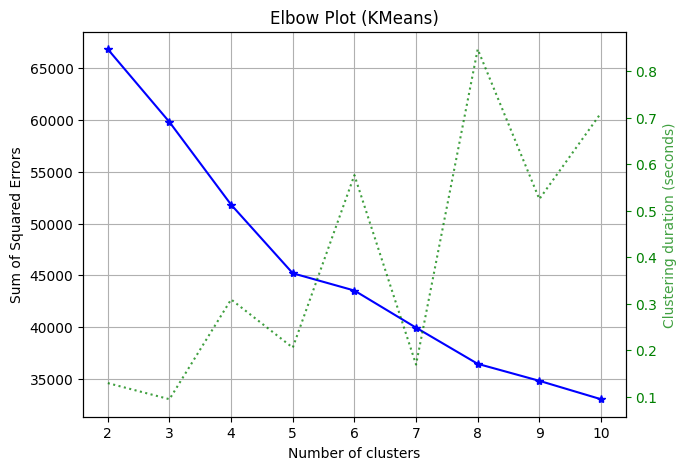

  OK: plot_elbow_curve saved


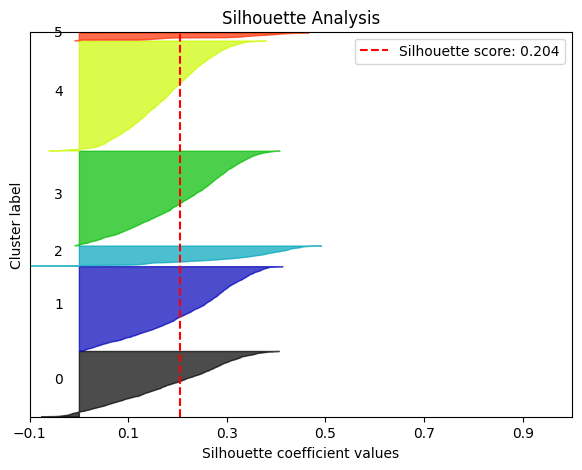

  OK: plot_silhouette saved


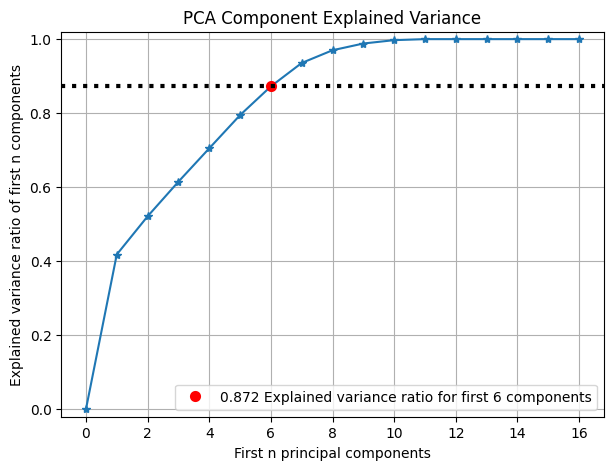

  OK: plot_pca_component_variance saved


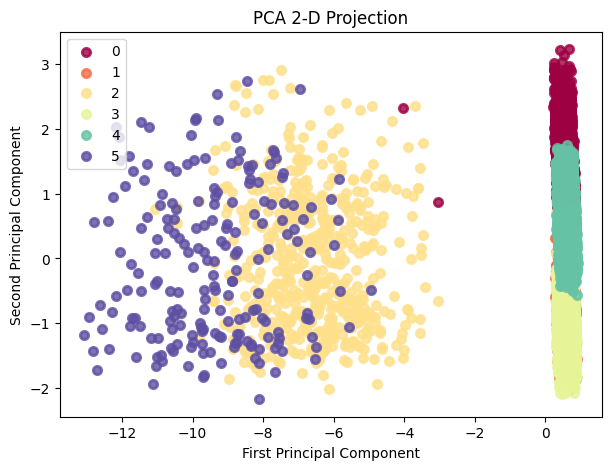

  OK: plot_pca_2d_projection saved


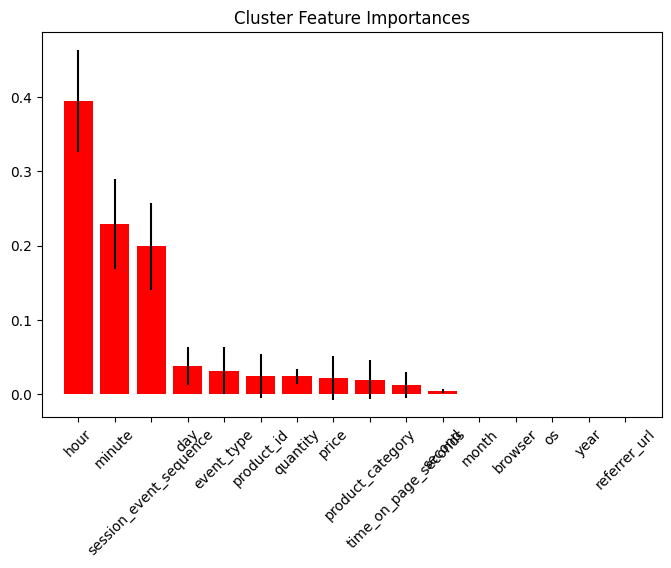

  OK: plot_feature_importances saved

Saved 5 scikit-plot visualizations.


In [23]:
scikitplot_config = scikitplot_clustering_kwargs()
scikitplot_results = scikitplot_clustering_visualizers(scikitplot_config)